# Bike Sharing 

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics

from datetime import datetime
from collections import Counter

%matplotlib inline

### Import data

In [3]:
station_df = pd.read_csv('data/station.csv')
trip_df = pd.read_csv('data/trip.csv')
weather_df = pd.read_csv('data/weather.csv')

### Process Data


In [4]:
#Convert to datetime so that it can be manipulated more easily
trip_df.start_date = pd.to_datetime(trip_df.start_date, format='%m/%d/%Y %H:%M')
trip_df.end_date = pd.to_datetime(trip_df.end_date, format='%m/%d/%Y %H:%M')

#duration is time of trip in seconds; convert to minutes
trip_df.duration = trip_df.duration / 60
trip_df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

### Examine station data

In [5]:
station_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [6]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int64
name                 70 non-null object
lat                  70 non-null float64
long                 70 non-null float64
dock_count           70 non-null int64
city                 70 non-null object
installation_date    70 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 3.9+ KB


In [7]:
#look for missing data; should be zero as info summary above gives 70 entries for each column
station_df.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

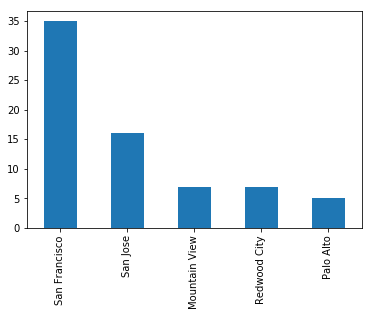

In [8]:
#stations by city
station_df.city.value_counts().plot(kind='bar')
# SF has 35 stations

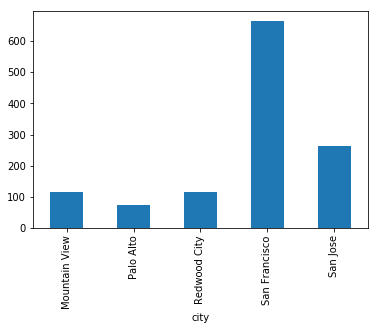

In [9]:
# number of docks per city   
station_df.groupby('city')['dock_count'].sum().plot(kind='bar')
# SF has 665

### Narrow focus to SF

In [10]:
# Narrow focus to SF stations
sf_stations = station_df[station_df.city == 'San Francisco']
sf_stations.head()

,id,name,lat,long,dock_count,city,installation_date
32,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,8/19/2013
33,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,8/19/2013
34,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,8/19/2013
35,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,8/19/2013
36,47,Post at Kearney,37.788975,-122.403452,19,San Francisco,8/19/2013


In [11]:
# Narrow focus to SF trips
sf_id = list(sf_stations.id)
sf_trips = trip_df[trip_df.start_station_id.isin(sf_id)]
sf_trips.start_station_id.unique()

array([66, 59, 49, 64, 41, 47, 67, 74, 39, 58, 56, 55, 61, 72, 45, 76, 62,
       46, 68, 71, 69, 73, 48, 75, 70, 50, 77, 65, 60, 42, 54, 57, 51, 63,
       82])

### Examine SF trip data

In [12]:
sf_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103
10,4549,2.083333,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109


In [13]:
sf_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603708 entries, 0 to 669958
Data columns (total 11 columns):
id                    603708 non-null int64
duration              603708 non-null float64
start_date            603708 non-null datetime64[ns]
start_station_name    603708 non-null object
start_station_id      603708 non-null int64
end_date              603708 non-null datetime64[ns]
end_station_name      603708 non-null object
end_station_id        603708 non-null int64
bike_id               603708 non-null int64
subscription_type     603708 non-null object
zip_code              597599 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 55.3+ MB


In [14]:
sf_trips.duration.describe()         ####Before 

count    603708.000000
mean         17.117811
std         380.557814
min           1.000000
25%           5.916667
50%           8.750000
75%          12.600000
max      287840.000000
Name: duration, dtype: float64

In [22]:
# Create column denoting weekend or weekday: DOW

sf_trips['weekday'] = pd.DatetimeIndex(sf_trips.start_date).dayofweek

sf_trips['DOW'] = None
sf_trips['DOW'] = ['weekend' if day in [5,6] else "weekday" for day in sf_trips['weekday']]
sf_trips = sf_trips.copy()

In [18]:
sf_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,weekday,DOW
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,weekday
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,3,weekday
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109,3,weekday
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,3,weekday
10,4549,2.083333,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109,3,weekday


In [19]:
# Remove outliers
# large std of 380.557814 and 3Q = 12.6; use quantiles instead of 3SD

np.quantile(sf_trips.duration, .98)  #102.64766666666645

102.64766666666645

In [20]:
sf_trips_clean = sf_trips.loc[sf_trips.duration < np.quantile(sf_trips.duration, 0.98)]

In [ ]:
#Boxplot before and after removal of outliers
#sf_trips vs sf_trips_clean


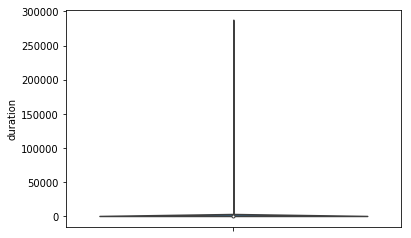

In [100]:
sb.violinplot(sf_trips['duration'], orient='v', showfliers=False)

In [96]:
sf_trips.duration.describe()         ####Before talk about values


count    603708.000000
mean         17.117811
std         380.557814
min           1.000000
25%           5.916667
50%           8.750000
75%          12.600000
max      287840.000000
Name: duration, dtype: float64

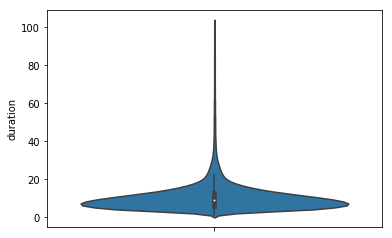

In [112]:
sb.violinplot(sf_trips_clean['duration'], orient='v', showfliers=False)

In [113]:
sf_trips_clean.duration.describe()         ####after talk about values


count    591633.000000
mean         10.652207
std           9.414143
min           1.000000
25%           5.866667
50%           8.616667
75%          12.300000
max         102.633333
Name: duration, dtype: float64

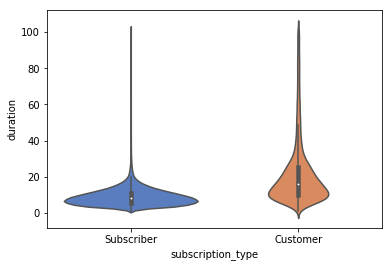

In [110]:
sb.violinplot(x='subscription_type', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

In [ ]:
#weekday vs weekend riders

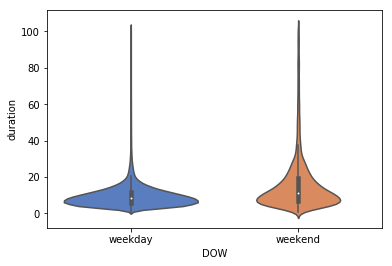

In [111]:
sb.violinplot(x='DOW', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

In [62]:
sf_subs = sf_trips_clean.groupby('subscription_type')

In [ ]:
# Compare counts of trips per hour weekday vs weekend

In [65]:
weekday_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.DOW == 'weekday'].start_date).hour
weekend_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.DOW == 'weekend'].start_date).hour

In [70]:
weekday_counts = Counter(weekday_counts)
weekend_counts = Counter(weekend_counts)

In [44]:
##for i in weekday_counts:
  ##  counts_prop = weekday_counts[i] / sum(weekday_counts.values())
    ##weekday_counts[i] = counts_prop

In [72]:
weekday_props = {hour:weekday_counts[hour]/sum(weekday_counts.values()) for hour in weekday_counts}
weekend_props = {hour:weekend_counts[hour]/sum(weekend_counts.values()) for hour in weekend_counts}

In [83]:
xd = range(0,24)
yd = [weekday_props[hour] for hour in range(0,24)]

xe = range(0,24)
ye = [weekend_props[hour] for hour in range(0,24)]

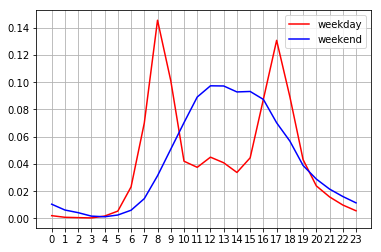

In [91]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(xd, yd, 'r-', xe, ye, 'b-')
plt.xticks(xe)

ax.legend(['weekday', 'weekend'])
ax.grid()

###labels, prop of bikes at start tiem


In [61]:
sum(weekend_counts.values())

73115

In [ ]:
1. Clean up and Data Exploration:
    box plots of clean up of outliers

2. Data Story:
    Ask the following questions and look for the answers using code and plots:
        Can you count something interesting?
        Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?
        Can you make a bar plot or a histogram?
        Can you compare two related quantities?
        Can you make a scatterplot?
        Can you make a time-series plot?
    Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?
    Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?
    
3.  Statistics:   
    The questions you asked
    The trends you investigated
    The resulting visualizations and conclusions
